In [45]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import pickle as pkl
from schnetpack.nn import build_mlp
from sklearn.metrics import r2_score, root_mean_squared_error 

from typing import Sequence, Union, Callable, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

import schnetpack as spk
import schnetpack.nn as snn
import schnetpack.properties as properties

# from torch.optim.lr_scheduler import StepLR

In [46]:
device = torch.device("cuda:1")

### Load Data

In [47]:
!pwd

/home/maligina/yana/gnn


In [48]:
!ls ../data/

conformers_1_chromophore_train.db  train_clean.csv
test_clean.csv			   train_clean_scalar_painn_test.pkl
test_clean_scalar_painn.pkl	   train_clean_scalar_painn_train.pkl


### Target: Emission_max_nm

In [49]:
train_data = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/train_clean_scalar_dimenet_train.pkl')
test_data = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/train_clean_scalar_dimenet_test.pkl')
test_eval = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/test_clean_scalar_dimenet.pkl')

train_tensor = torch.stack(train_data['Concatenated_embedding'].to_list(), dim=0)
train_target = torch.FloatTensor(train_data['Emission_max_nm'].to_list())
mean_train = train_target.mean()
std_train = train_target.std()
train_target_norm = (train_target - train_target.mean()) / train_target.std()
train_dataset = TensorDataset(train_tensor, train_target_norm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_tensor = torch.stack(test_data['Concatenated_embedding'].to_list(), dim=0)
test_target = torch.FloatTensor(test_data['Emission_max_nm'].to_list())
test_target_norm = (test_target - test_target.mean()) / test_target.std()
test_dataset = TensorDataset(test_tensor, test_target_norm)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_eval_tensor = torch.stack(test_eval['Concatenated_embedding'].to_list(), dim=0)
test_eval_target = torch.FloatTensor(test_eval['Emission_max_nm'].to_list())
test_eval_target_norm = (test_eval_target - test_eval_target.mean()) / test_eval_target.std()
test_eval_dataset = TensorDataset(test_eval_tensor, test_eval_target_norm)
test_eval_loader = DataLoader(test_eval_dataset, batch_size=32, shuffle=True)

In [50]:
for i, batch in enumerate(test_loader):
    inputs, labels = batch
    
    # Check for NaN values in inputs and labels
    if torch.isnan(inputs).any():
        print(f"NaN detected in inputs at batch {i}")
        
    if torch.isnan(labels).any():
        print(f"NaN detected in labels at batch {i}")

NaN detected in inputs at batch 2
NaN detected in inputs at batch 3
NaN detected in inputs at batch 5
NaN detected in inputs at batch 6
NaN detected in inputs at batch 7
NaN detected in inputs at batch 8
NaN detected in inputs at batch 9
NaN detected in inputs at batch 10
NaN detected in inputs at batch 11
NaN detected in inputs at batch 12
NaN detected in inputs at batch 14
NaN detected in inputs at batch 22
NaN detected in inputs at batch 30
NaN detected in inputs at batch 31


In [51]:
class MLPModel(nn.Module):
    def __init__(self, n_in, n_out, n_hidden, n_layers, activation):
        super().__init__()
        self.mlp = spk.nn.build_mlp(
            n_in=n_in,
            n_out=n_out,
            n_hidden=n_hidden,
            n_layers=n_layers,
            activation=activation,
        )

    def forward(self, emb):
        return self.mlp(emb)

In [1]:
model = MLPModel(256, 1, [512, 256, 128], n_layers=4, activation=F.silu)
model.to(device)

NameError: name 'MLPModel' is not defined

In [53]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [54]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.squeeze(1), labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [55]:
# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0
EPOCHS = 500

train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss_values.append(avg_loss)
    
    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to("cuda:1")
            vlabels = vlabels.to("cuda:1")
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs.squeeze(1), vlabels).item()
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_loss_values.append(avg_vloss)
    
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # scheduler.step()
    scheduler.step(avg_vloss)

    epoch_number += 1

EPOCH 1:


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x100 and 256x512)

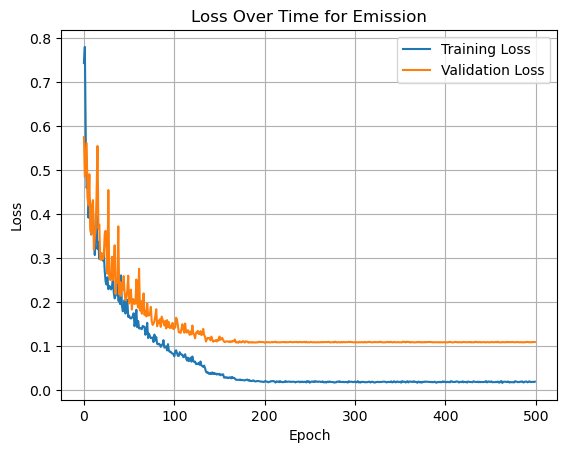

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss values
plt.plot(train_loss_values, label='Training Loss')
plt.plot([val for val in val_loss_values], label='Validation Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.title('Loss Over Time for Emission')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# After training, evaluate the model on test data
model.eval()  # Set the model to evaluation mode
running_test_loss = 0.0

# Lists to store actual and predicted values
actual_values = []
predicted_values = []

with torch.no_grad():  # Disable gradient calculation
    for i, data in enumerate(test_eval_loader):
        inputs, labels = data
        inputs = inputs.to("cuda:1")
        labels = labels.to("cuda:1")
        
        # Forward pass through the model
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(1), labels)
                
        # Append actual and predicted values to lists
        actual_values.extend(labels.cpu().numpy())
        predicted_values.extend(outputs.squeeze(1).cpu().numpy())

        running_test_loss += loss.item()

# Calculate the average loss over the test dataset
avg_test_loss = running_test_loss / (i + 1)

actual_values_unscaled = [i * std_train.item() + mean_train.item() for i in actual_values]
predicted_values_unscaled = [i * std_train.item() + mean_train.item() for i in predicted_values]

# Compute R^2 and RMSE
r2 = np.corrcoef(actual_values_unscaled, predicted_values_unscaled)[0,1] **2
rmse = root_mean_squared_error(actual_values_unscaled, predicted_values_unscaled)

print(f"R^2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Average test loss: {avg_test_loss}")


R^2: 0.889
RMSE: 31.558
Average test loss: 0.11118763337976166
